In [1]:
using Random, JuMP, Clp, Ipopt, LinearAlgebra, SparseArrays, DifferentialEquations, Plots, Sundials, LaTeXStrings, ForwardDiff 
Random.seed!(1)

# Solving: min f(x), s.t. g(x)>=0, x>=0
n = 5
m = 2
A = 2.0*rand(m,n) .- 1.0
b = 2.0*rand(m) .- 1.0
# To make the NLP infeasible, we add the contradictory constraint: sum(x)<=-1
A = [A; -ones(1,n)]
b = [b; 1.0]
m = m + 1
Prob = Model(Ipopt.Optimizer)
@variable(Prob, x[1:n]>=0)
@objective(Prob, Min, sum(exp.(x)))
@constraint(Prob, A*x-b .>= 0)
optimize!(Prob)
x_opt = [value(x[i]) for i in 1:n]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       15
Number of nonzeros in Lagrangian Hessian.............:        5

Total number of variables............................:        5
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

5-element Vector{Float64}:
 -9.949756000888876e-9
 -9.95464622898702e-9
 -9.809615310109763e-9
 -9.693233356861187e-9
 -9.869272541813574e-9

In [2]:
function Homogeneous_massfun(z,A,b,n,m)
    x = z[1:n]
    y = z[n+1:n+m]
    tau = z[n+m+1]
    s = z[n+m+1+1:n+m+1+n]
    v = z[n+m+1+n+1:n+m+1+n+m]
    kappa = z[n+m+1+n+m+1]
    M31 = -exp.(x/tau).-(x/tau).*exp.(x/tau)
    M32 = b
    M33 = 1/tau^2*x'*Diagonal(exp.(x/tau))*x
    nabla_psi = [Diagonal(exp.(x/tau)) -A' exp.(x/tau).-(x/tau).*exp.(x/tau);
                 A zeros(m,m) -b;
                 M31' M32' M33]
    M = [nabla_psi -I(n+m+1);
         Diagonal([s;v;kappa]) Diagonal([x;y;tau])]    
    return M
end

function Homogeneous_odefun(z,A,b,n,m,k)
    x = z[1:n]
    y = z[n+1:n+m]
    tau = z[n+m+1]
    s = z[n+m+1+1:n+m+1+n]
    v = z[n+m+1+n+1:n+m+1+n+m]
    kappa = z[n+m+1+n+m+1]
    temp = [tau*exp.(x/tau)-A'*y - s;
            A*x-tau*b - v;
            -x'*exp.(x/tau)+y'*b - kappa;
            x.*s;
            y.*v;
            tau*kappa]
    dzdt = -k*(1/norm(temp)+norm(temp))*temp
    return dzdt
end

function Homogeneous_ode!(residual, dz, z, p, t)
    A, b, n, m, k = p
    residual .=  Homogeneous_massfun(z,A,b,n,m) * dz - Homogeneous_odefun(z,A,b,n,m,k)
end

Homogeneous_ode! (generic function with 1 method)

In [3]:
Tp = 1.0
k = 2*pi/(4.0*Tp)
Tmax = 0.999*Tp
p = (A,b,n,m,k)
z0 = 20*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol = solve(Homogeneous_prob,abstol=1e-8,reltol=1e-8,saveat=t_points;alg_hints=[:stiff])
sol = solve(Homogeneous_prob,DFBDF(),saveat=t_points)
tau_equi = sol[n+m+1,end]
kappa_equi = sol[n+m+1+n+m+1,end]
if tau_equi<kappa_equi
    println("The problem is infeasible")
end

The problem is infeasible


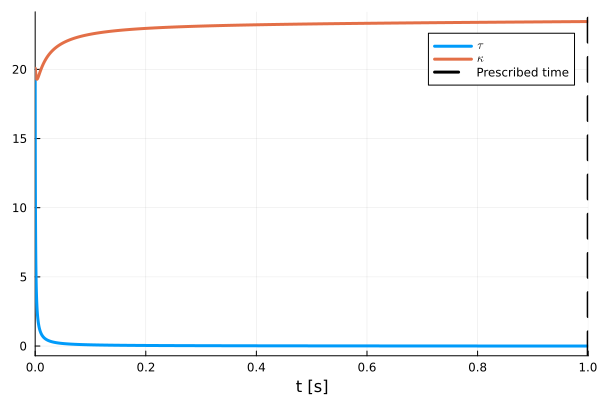

In [4]:
tau_traj = sol[n+m+1,:]
kappa_traj = sol[n+m+1+n+m+1,:]
plot(sol.t,tau_traj,linewidth=3,xlabel="t [s]",label=L"$\tau$")
plot!(sol.t,kappa_traj,linewidth=3,label=L"$\kappa$")
vline!([Tp], linestyle=:dash, color=:black,linewidth=3, label="Prescribed time")
xlims!(0, 1.0)
# ylims!(0, 10)
plot!(legend=(0.8,0.9))

In [5]:
savefig("Fig9_NLP_Infeasible.pdf")

"/Users/liang/Documents/Julia/AnalogOpti_Code_v1/Fig9_NLP_Infeasible.pdf"

In [6]:
# check the rate of infeasibility detecting 
num_cases = 100
counter = 0
for i=1:num_cases
    n = 5
    m = 2
    A = 2.0*rand(m,n) .- 1.0
    b = 2.0*rand(m) .- 1.0
    # To make the LP infeasible, we add the contradictory constraint: sum(x)<=-1
    A = [A; -ones(1,n)]
    b = [b; 1.0]
    m = m + 1   
    # check whether the fixed-time-stable ODE method successfully detecting the infeasibility
    Tp = 1.0
    k = 2*pi/(4.0*Tp)
    Tmax = 0.99*Tp
    p = (A,b,n,m,k)
    z0 = 5*ones(2*(n+m+1))
    dz0 = zeros(2*(n+m+1))
    tspan = (0.0, Tmax)
    differential_vars = [true for _ in 1:2*(n+m+1)]
    Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p, differential_vars = differential_vars)
    t_points = range(tspan[1],tspan[2],length=10000)
    sol = solve(Homogeneous_prob,DFBDF(),saveat=t_points)
    tau_equi = sol[n+m+1,end]
    kappa_equi = sol[n+m+1+n+m+1,end]
    if tau_equi<kappa_equi
        counter = counter + 1 
    end
end
rate = counter/num_cases
println("The rate of infeasibility detecting is ", rate)


The rate of infeasibility detecting is 1.0
